In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Pfade
BASE = Path.cwd().parent
PROC = BASE / "data" / "processed"
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

# Daten laden
fact = pd.read_parquet(PROC / "fact_order_items.parquet")[
    ["order_id","customer_id","order_date"]  # order_date ist in der Fact als Datum vorhanden
].drop_duplicates()

orders = pd.read_csv(
    RAW / "olist_orders_dataset.csv",
    usecols=["order_id","customer_id","order_purchase_timestamp","order_status"],
    parse_dates=["order_purchase_timestamp"]
)
customers = pd.read_csv(
    RAW / "olist_customers_dataset.csv",
    usecols=["customer_id","customer_unique_id"]
)

# Nur gelieferte Bestellungen (Kohorten auf echte Käufe)
orders = orders[orders["order_status"]=="delivered"].copy()

# Customer Unique ID anhängen
orders = orders.merge(customers, on="customer_id", how="left")

# Monatsspalte
orders["order_month"] = orders["order_purchase_timestamp"].dt.to_period("M")

print("orders:", orders.shape, "fact:", fact.shape)
orders.head(3)


orders: (96478, 6) fact: (98199, 3)


,order_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08


In [33]:
# Erstkaufmonat je Kunde
first_order = orders.groupby("customer_unique_id")["order_month"].min().rename("cohort_month")

# Kohorte an jede Bestellung anhängen
orders = orders.merge(first_order, on="customer_unique_id", how="left")

# Kohortenindex (0 = Erstkaufmonat, 1 = Folgemonat, …)
orders["cohort_index"] = (orders["order_month"] - orders["cohort_month"]).apply(lambda p: p.n)

orders[["customer_unique_id","order_month","cohort_month","cohort_index"]].head()


,customer_unique_id,order_month,cohort_month,cohort_index
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09,1
1,af07308b275d755c9edb36a90c618231,2018-07,2018-07,0
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08,0
3,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11,0
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02,0


In [34]:
# Anzahl aktiver Kunden je Kohorte x Index
cohort_counts = (
    orders.groupby(["cohort_month","cohort_index"])["customer_unique_id"]
    .nunique().reset_index(name="active_customers")
)

# Pivot: Zeilen = Kohortenmonat, Spalten = Index
cohort_pivot = cohort_counts.pivot(index="cohort_month", columns="cohort_index", values="active_customers").fillna(0).astype(int)

# Kohortengröße = Spalte 0
cohort_size = cohort_pivot.iloc[:,0].replace(0, np.nan)

# Retention in %
retention = (cohort_pivot.divide(cohort_size, axis=0)).round(3)

display(cohort_pivot.head())
display(retention.head())


cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-10,262,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,2,2
2016-12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01,717,2,2,1,3,1,3,1,1,0,3,1,5,3,1,1,2,3,1,0
2017-02,1628,3,5,2,7,2,4,3,2,3,2,5,2,3,2,1,1,3,0,0


cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2016-10,1.0,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.004,0.000,0.004,0.000,0.004,0.000,0.004,0.000,0.004,0.008,0.008
2016-12,1.0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-01,1.0,0.003,0.003,0.001,0.004,0.001,0.004,0.001,0.001,0.000,0.004,0.001,0.007,0.004,0.001,0.001,0.003,0.004,0.001,0.000
2017-02,1.0,0.002,0.003,0.001,0.004,0.001,0.002,0.002,0.001,0.002,0.001,0.003,0.001,0.002,0.001,0.001,0.001,0.002,0.000,0.000


plt.figure(figsize=(12,6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues", cbar_kws={"label":"Retention"})
plt.title("Kunden-Retention nach Kohorte (Monate seit Erstkauf)")
plt.xlabel("Monate seit Erstkauf (Cohort Index)")
plt.ylabel("Kohortenmonat")
plt.tight_layout()
plt.show()


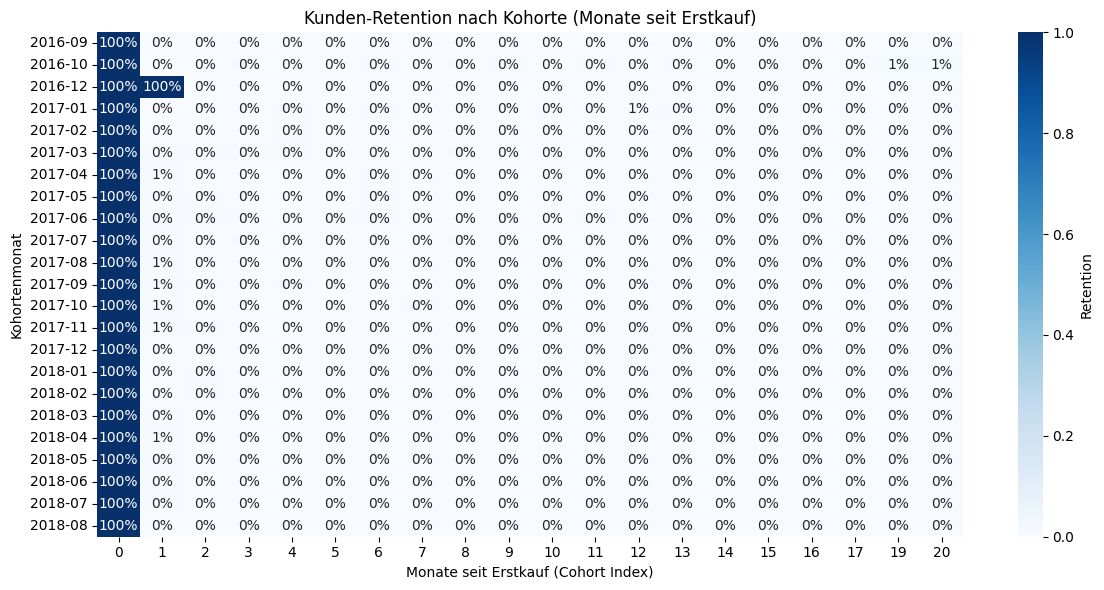

In [35]:
plt.figure(figsize=(12,6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues", cbar_kws={"label":"Retention"})
plt.title("Kunden-Retention nach Kohorte (Monate seit Erstkauf)")
plt.xlabel("Monate seit Erstkauf (Cohort Index)")
plt.ylabel("Kohortenmonat")
plt.tight_layout()
plt.show()


In [36]:
# --- Minimal-Setup für Kohortenvergleich ---
import pandas as pd
from pathlib import Path

BASE = Path.cwd().parent
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

# Orders + Customers laden und zusammenführen
orders = pd.read_csv(
    RAW / "olist_orders_dataset.csv",
    usecols=["order_id","customer_id","order_purchase_timestamp","order_status"],
    parse_dates=["order_purchase_timestamp"],
)
customers = pd.read_csv(
    RAW / "olist_customers_dataset.csv",
    usecols=["customer_id","customer_unique_id"]
)

orders = (
    orders[orders["order_status"] == "delivered"]    # nur echte Käufe
      .merge(customers, on="customer_id", how="left")
      .dropna(subset=["customer_unique_id", "order_purchase_timestamp"])
)

# Sanity check
print(orders.columns.tolist())
print("Rows:", len(orders), 
      "unique customer_id:", orders["customer_id"].nunique(), 
      "unique customer_unique_id:", orders["customer_unique_id"].nunique())


['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'customer_unique_id']
Rows: 96478 unique customer_id: 96478 unique customer_unique_id: 93358


In [37]:
import numpy as np

def build_cohort(df: pd.DataFrame, id_col: str) -> pd.DataFrame:
    # defensiv kopieren & nur benötigte Spalten
    cols = [id_col, "order_purchase_timestamp"]
    df = df[cols].dropna().copy()

    # Monatsperioden
    df["order_month"] = df["order_purchase_timestamp"].dt.to_period("M")

    # Erstkauf je ID
    first_order = df.groupby(id_col)["order_month"].min().rename("cohort_month")
    df = df.merge(first_order, on=id_col, how="left")

    # Index = Monate seit Erstkauf
    df["cohort_index"] = (df["order_month"] - df["cohort_month"]).apply(lambda p: p.n)

    # Aggregation
    grp = (df.groupby(["cohort_month","cohort_index"])[id_col]
             .nunique()
             .reset_index(name="active_customers"))

    if "cohort_month" not in grp.columns:
        raise ValueError("cohort_month fehlt – prüfe, ob order_month/cohort_month korrekt erzeugt wurde.")

    # Pivot & Retention
    pivot = (grp.pivot(index="cohort_month", columns="cohort_index", values="active_customers")
               .fillna(0)
               .astype(int))
    cohort_size = pivot.iloc[:, 0].replace(0, np.nan)
    retention = pivot.divide(cohort_size, axis=0)

    return retention.round(3)


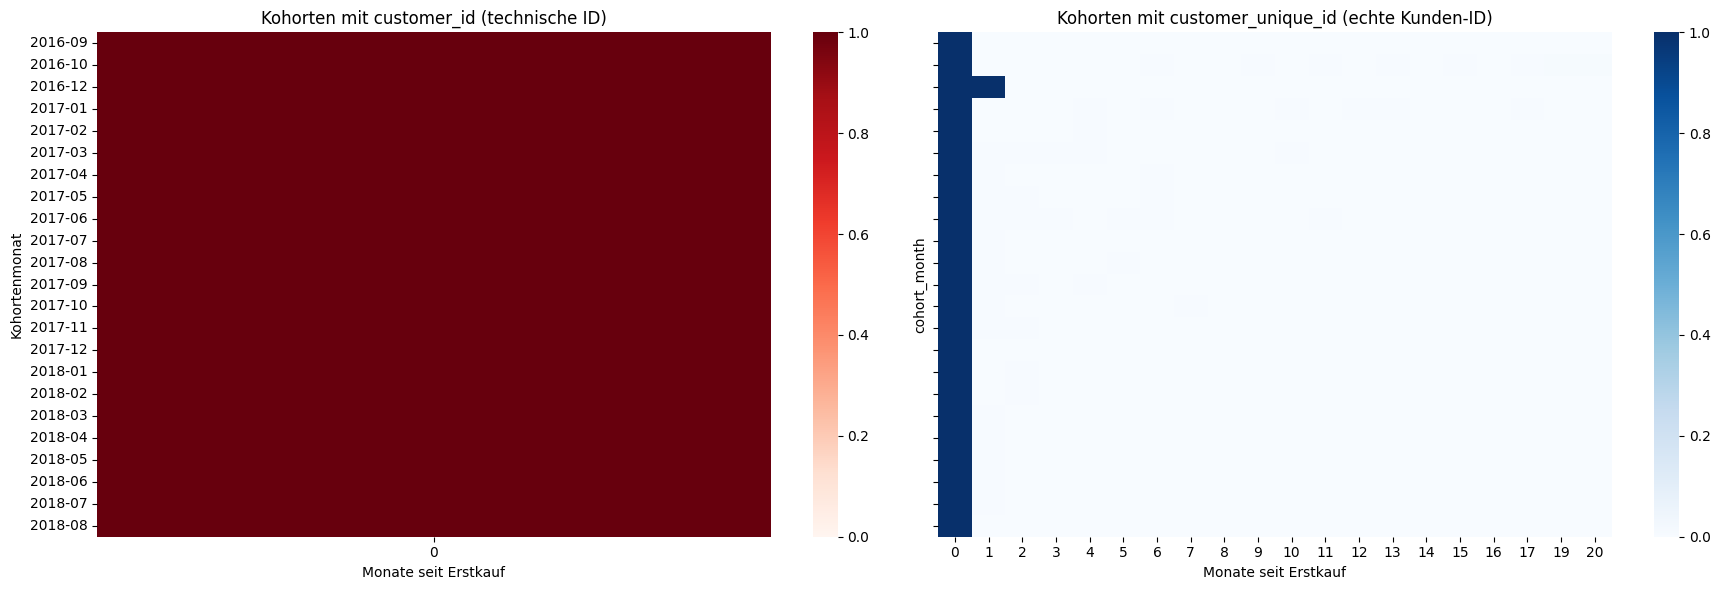

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

retention_id     = build_cohort(orders, "customer_id")
retention_unique = build_cohort(orders, "customer_unique_id")

vmin, vmax = 0, 1
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.heatmap(retention_id,     annot=False, cmap="Reds",  vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title("Kohorten mit customer_id (technische ID)")
axes[0].set_xlabel("Monate seit Erstkauf"); axes[0].set_ylabel("Kohortenmonat")

sns.heatmap(retention_unique, annot=False, cmap="Blues", vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title("Kohorten mit customer_unique_id (echte Kunden-ID)")
axes[1].set_xlabel("Monate seit Erstkauf")

plt.tight_layout(); plt.show()


Gesamtzahl Kunden: 93,358
Wiederbesteller (mehr als 1 Bestellung): 2,801
Anteil Wiederbesteller: 3.00%


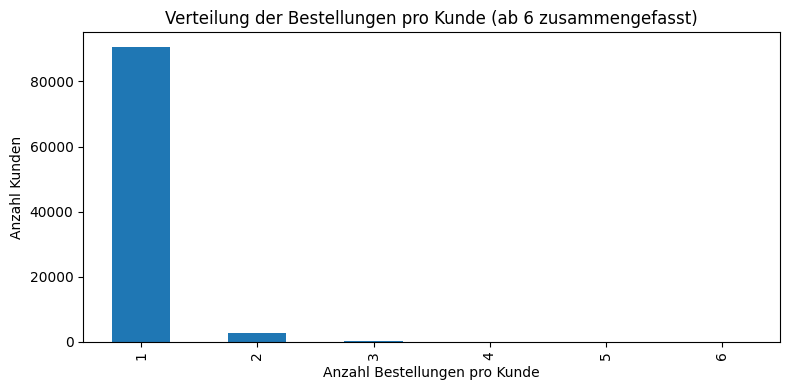

In [39]:
# Wiederbestellungen pro Kunde berechnen
orders_per_customer = (
    orders.groupby("customer_unique_id")["order_id"]
    .nunique()
    .rename("order_count")
)

# Kennzahlen
total_customers = len(orders_per_customer)
repeat_customers = (orders_per_customer > 1).sum()
repeat_share = repeat_customers / total_customers * 100

print(f"Gesamtzahl Kunden: {total_customers:,}")
print(f"Wiederbesteller (mehr als 1 Bestellung): {repeat_customers:,}")
print(f"Anteil Wiederbesteller: {repeat_share:.2f}%")

# Verteilung der Bestellanzahl pro Kunde
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
orders_per_customer.clip(upper=6).value_counts().sort_index().plot(kind="bar")
plt.title("Verteilung der Bestellungen pro Kunde (ab 6 zusammengefasst)")
plt.xlabel("Anzahl Bestellungen pro Kunde")
plt.ylabel("Anzahl Kunden")
plt.tight_layout()
plt.show()
